# TCC - Uso de _transformers_ na previsão da evasão de IES públicas no Brasil
## Treinamento do modelo

# Imports

In [1]:
import keras
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers
from keras import ops
from functools import partial
from pathlib import Path
from tensorflow import data as tf_data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore') 

# Importação e preparação dos dados

In [ ]:
filepath = Path('data')
filename = 'treated_db.csv'

In [ ]:
df = pd.read_csv(filepath/filename)
df.dropna(inplace=True)
df = df[df['QT_TOT'] != 0].reset_index(drop=True)
df.head(3)

## Transforma as colunas de quantidade em porcentagem em relação à `QT_TOT`

In [ ]:
for col in df.columns:
    if col.startswith('QT') and col != 'QT_TOT': df[col] = df[col] / df['QT_TOT']

In [ ]:
df.drop([191, 108], inplace=True)
df.QT_DESISTENCIA.sort_values()

In [ ]:
extremos_desist = {
    'min': df.QT_DESISTENCIA.min(),
    'max': df.QT_DESISTENCIA.max()
}

In [ ]:
extremos_desist

## Normaliza os valores de evasão entre 0 e 1 utilizando MinMax

In [ ]:
df['QT_DESISTENCIA'] = (df['QT_DESISTENCIA'] - df['QT_DESISTENCIA'].min()) / (df['QT_DESISTENCIA'].max() - df['QT_DESISTENCIA'].min())
df.head(3)

### Retira _outliers_ e reaplica normalização

In [ ]:
df.QT_DESISTENCIA.sort_values()

## Aplica _binning_ para a taxa de evasão

In [ ]:
ID2LABEL = {i: f'Nivel {i+1}' for i in range(10)}
LABEL2ID = {f'Nivel {i+1}': i for i in range(10)}

In [ ]:
def apply_label(value: float):
    if value < 0.1: return 0
    if value < 0.2: return 1
    if value < 0.3: return 2
    if value < 0.4: return 3
    if value < 0.5: return 4
    if value < 0.6: return 5
    if value < 0.7: return 6
    if value < 0.8: return 7
    if value < 0.9: return 8
    else:           return 9

In [ ]:
df['id_label'] = df['QT_DESISTENCIA'].apply(apply_label)

In [ ]:
value_counts = df.id_label.value_counts()
value_counts.rename(ID2LABEL, inplace=True)
display(value_counts)
plt.figure() 
value_counts.plot.bar(
    xlabel='Nível',
    ylabel='Quantidade de dados',
    color='#0c343d',
    rot=45, 
    legend=False
)
plt.tight_layout()

## Aplica técnicas de SMOTE para balancear os dados

### Mapeia regiões

In [ ]:
REGION2ID = {
    'Norte':        0,
    'Nordeste':     1,
    'Centro-Oeste': 2,
    'Sudeste':      3,
    'Sul':          4
}

ID2REGION = {
    0: 'Norte',
    1: 'Nordeste',
    2: 'Centro-Oeste',
    3: 'Sudeste',
    4: 'Sul'
}

df['NO_REGIAO'] = df['NO_REGIAO'].apply(lambda x: REGION2ID[x])

In [ ]:
X = df.drop('id_label', axis=1)
y = df['id_label']

In [ ]:
steps = [
    ('increase', SMOTE(sampling_strategy={0: 1300}, k_neighbors=1)),
    ('over',     SMOTE(sampling_strategy='auto', k_neighbors=1))
]
pipeline = Pipeline(steps=steps)
transformed = pipeline.fit_resample(X, y)

In [ ]:
df_transformed = transformed[0]
df_transformed['id_label'] = transformed[1]
df_transformed.head(3)

In [ ]:
df_transformed['NO_REGIAO'] = df_transformed['NO_REGIAO'].apply(lambda x: ID2REGION[x])

In [ ]:
value_counts = df_transformed.id_label.value_counts()
value_counts.sort_index(inplace=True)
value_counts.rename(ID2LABEL, inplace=True)
value_counts

# Treinamento do modelo

## Última tratativa de dados

### Retira as colunas abaixo que não são necessárias para o treinamento

In [ ]:
data = df_transformed.drop(['CO_IES', 'NU_ANO_CENSO', 'QT_TOT', 'QT_DESISTENCIA'], axis=1)
data.head(3)

### Retorna a coluna `label` para o DataFrame

In [ ]:
data['label'] = data['id_label'].apply(lambda x: ID2LABEL[x])
data.drop('id_label', inplace=True, axis=1)
data.head(3)

### Adiciona a coluna _weights_, necessária para o treinamento

In [ ]:
data['weights'] = 1
data.head(3)

### Randomiza a ordem dos dados

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

### Salva os _datasets_ de treino e teste em formato CSV

In [ ]:
for_training_path = filepath / Path('for_training')

In [ ]:
train = data.iloc[:9101] # 70% treino
train.to_csv(for_training_path / 'train_data.csv', index=False, header=False)

train.label.value_counts()

In [ ]:
test = data.iloc[9101:] # 30% teste
test.to_csv(for_training_path / 'test_data.csv', index=False, header=False)

test.label.value_counts()

## TabTransformer

A arquitetura _TabTransformer_ funciona da seguinte maneira:

1. Todas as características categóricas são codificadas como _embeddings_, usando o mesmo `embedding_dims`. Isso significa que cada valor em cada característica categórica terá seu próprio vetor de _embedding_.

2. Um _embedding_ de coluna, um vetor de _embedding_ para cada característica categórica, é adicionado (ponto a ponto) ao _embedding_ da característica categórica.

3. As características categóricas incorporadas são alimentadas a uma pilha de blocos _transformer_. Cada bloco _transformer_ consiste em uma camada de autoatenção multi-cabeça seguida por uma camada _feed-forward_.

4. As saídas da última camada _transformer_, que são os _embeddings_ contextuais das características categóricas, são concatenadas com as características numéricas de entrada e alimentadas a um bloco MLP final.

5. Um classificador _softmax_ é aplicado no final do modelo.

### Definição de constantes para o modelo

In [ ]:
CSV_HEADER = data.columns

In [ ]:
NUMERIC_FEATURE_NAMES = [col for col in data.columns if col.startswith('QT')]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {"NO_REGIAO": sorted(list(data["NO_REGIAO"].unique()))}
WEIGHT_COLUMN_NAME = "weights"
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

TARGET_FEATURE_NAME = "label"
TARGET_LABELS = list(LABEL2ID.keys())

In [ ]:
LEARNING_RATE = 0.0005
WEIGHT_DECAY  = 0.001
DROPOUT_RATE  = 0.5
BATCH_SIZE    = 64
NUM_EPOCHS    = 200

NUM_TRANSFORMER_BLOCKS   = 1
NUM_HEADS                = 2
EMBEDDING_DIMS           = 8
MLP_HIDDEN_UNITS_FACTORS = [2,1]

### Mapeia _strings_ para índices de _encode_

In [ ]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)

In [ ]:
def prepare_data(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights

### Realiza o _encode_ das grandezas categóricas

In [ ]:
lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    lookup = layers.StringLookup(
        vocabulary=vocabulary, mask_token=None, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup

In [ ]:
def encode_categorical(batch_x, batch_y, weights):
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        batch_x[feature_name] = lookup_dict[feature_name](batch_x[feature_name])

    return batch_x, batch_y, weights

### Função que gera um _dataset_ a partir dos arquivos CSV criados

In [ ]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = (
        tf_data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size      = batch_size,
            column_names    = CSV_HEADER,
            column_defaults = COLUMN_DEFAULTS,
            label_name      = TARGET_FEATURE_NAME,
            num_epochs      = 1,
            header          = False,
            na_value        = "?",
            shuffle         = shuffle,
        )
        .map(prepare_data, num_parallel_calls=tf_data.AUTOTUNE, deterministic=False)
        .map(encode_categorical)
    )
    return dataset.cache()

### Função responsável por gerir todo o _pipeline_, desde a tratativa dos arquivos até o treinamento e avaliação do modelo

In [ ]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath       = "models/model_last.keras",
        monitor        = "val_accuracy",
        save_best_only = True,
        mode           = "max",
        verbose        = 1
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor              = 'val_loss',
        patience             = 10,
        restore_best_weights = True
    )

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset, callbacks=[checkpoint_callback, early_stopping]
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history, model


### Função que define as entradas para os modelos como um dicionário, onde a chave é o nome do recurso, e o valor é um tensor `keras.layers.Input` com a forma e o tipo de dados correspondentes do recurso.

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="float32"
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype="int32"
            )
    return inputs


### Função que retorna `encoded_categorical_feature_list` e `numerical_feature_list`, codificando as características categóricas como _embeddings_, usando um `embedding_dims` fixo para todas as características, independentemente de seus tamanhos de vocabulário

In [ ]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

### Implementação de um bloco MLP

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

### Monta o bloco _TabTransformer_

In [ ]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a softmax as a class classifer.
    outputs = layers.Dense(units=len(TARGET_LABELS), activation="softmax", name="softmax")(features)
    model   = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())

### Roda o _loop_ de treino e validação

In [ ]:
history, model = run_experiment(
    model           = tabtransformer_model,
    train_data_file = 'data/for_training/train_data.csv',
    test_data_file  = 'data/for_training/test_data.csv',
    num_epochs      = NUM_EPOCHS,
    learning_rate   = LEARNING_RATE,
    weight_decay    = WEIGHT_DECAY,
    batch_size      = BATCH_SIZE,
)

In [2]:
training_history_path = 'data/for_training/training_history.csv'

In [ ]:
pd.DataFrame(history.history).to_csv(training_history_path)

# Resultados

## Gráficos do histórico de treinamento

In [3]:
history = pd.read_csv(training_history_path)

In [4]:
KEY2NAME = {
    'accuracy': 'Acurácia',
    'loss': 'Perda',
    'val_accuracy': 'Acurácia na Validação',
    'val_loss': 'Perda na Validação',
}

In [5]:
all_epochs = list(range(1, 200 + 1))

In [6]:
history.index = all_epochs

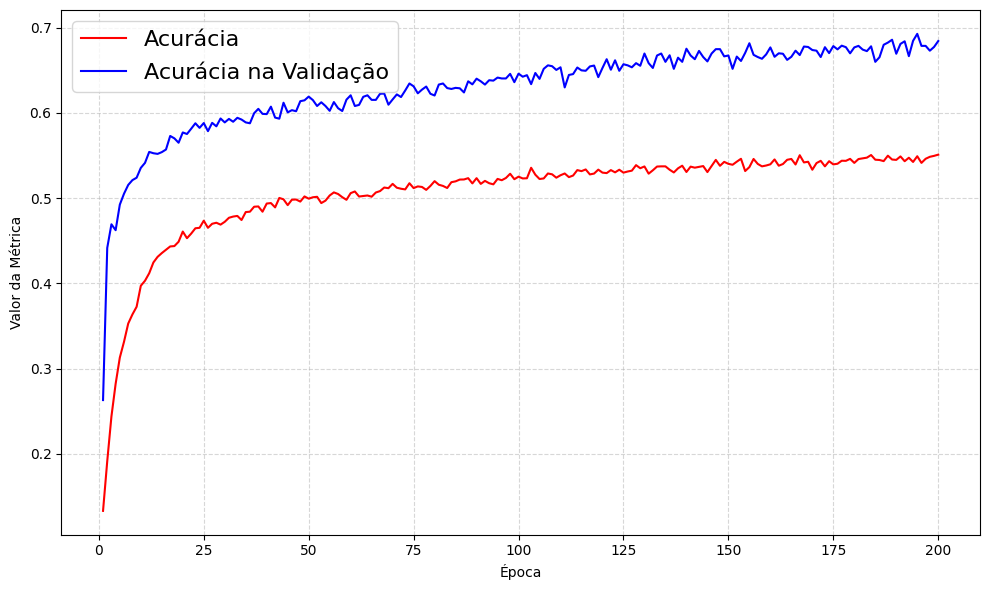

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.index, history.accuracy, label=KEY2NAME['accuracy'], color='red')
ax.plot(history.index, history.val_accuracy, label=KEY2NAME['val_accuracy'], color='blue')
ax.legend(fontsize="16")
ax.set_xlabel('Época')
ax.set_ylabel('Valor da Métrica')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

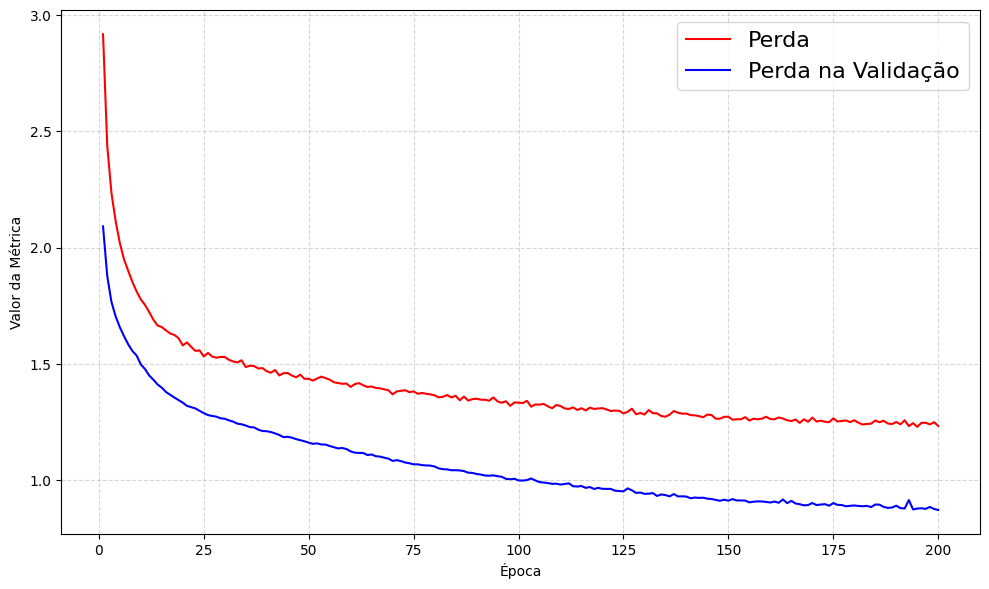

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.index, history.loss, label=KEY2NAME['loss'], color='red')
ax.plot(history.index, history.val_loss, label=KEY2NAME['val_loss'], color='blue')
ax.legend(fontsize="16")
ax.set_xlabel('Época')
ax.set_ylabel('Valor da Métrica')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## _Scatter plot_

In [ ]:
model = tf.keras.models.load_model('models\model_last.keras')

In [ ]:
test_data = get_dataset_from_csv('data/for_training/test_data.csv')
result    = model.predict(test_data)

In [ ]:
test_training = test.copy()
test_training['predictions'] = [ID2LABEL[list(tf.argmax(result, axis=1).numpy())[i]] for i in range(len(result))]

In [ ]:
level_map = {level: i for i, level in enumerate(TARGET_LABELS)}

# Aplicar o mapeamento aos dados
test_training['predictions_num'] = test_training['predictions'].map(level_map)
test_training['label_num']       = test_training['label'].map(level_map)

In [ ]:
test_training['label_num'].corr(test_training['predictions_num'])

In [ ]:
frequency = test_training.groupby(['predictions_num', 'label_num']).size().reset_index(name='frequency')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x=frequency['label_num'],
    y=frequency['predictions_num'],
    s=frequency['frequency'] * 5,  
    c=frequency['frequency'],      
    cmap='PuBu',                   
    alpha=0.75                     
)

plt.colorbar(scatter, label='Frequência')
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Original')
plt.show()

### Retorno aos valores originais

In [ ]:
test_training.label_num

In [ ]:
def return_norm(bins):
    return (bins + 0.5) / 10

In [ ]:
test_training.head(3)

In [ ]:
X_min = extremos_desist['min']
X_max = extremos_desist['max']

In [ ]:
labels      = return_norm(test_training.label_num)
predictions = return_norm(test_training.predictions_num)

In [ ]:
for col_name, col in zip(['back_labels', 'back_predictions'], [labels, predictions]):
    test_training[col_name] = (col * (X_max - X_min) + X_min)
    test_training[col_name] = test_training[col_name]*100

test_training.head(3)

In [ ]:
frequency = test_training.groupby(['back_predictions', 'back_labels']).size().reset_index(name='frequency')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x=frequency['back_labels'],
    y=frequency['back_predictions'],
    s=frequency['frequency'] * 5,  
    c=frequency['frequency'],     
    cmap='PuBu',                   
    alpha=0.75                     
)

plt.colorbar(scatter, label='Frequência')
plt.xlabel('Valor Previsto (%)')
plt.ylabel('Valor Original (%)')
plt.show()

## _Boxplot_

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=test_training, x='predictions_num', y='label_num', palette='viridis')
sns.stripplot(data=test_training, x='predictions_num', y='label_num', color='black', alpha=0.6, jitter=True)

plt.xlabel('Valor Previsto')
plt.ylabel('Valor Original')
plt.show()


## Correlações

In [ ]:
cols_etnias = ["QT_BRANCA", "QT_PRETA", "QT_PARDA", "QT_AMARELA", "QT_INDIGENA"]
df_corr = test_training[cols_etnias + ["label_num"]]
df_corr.rename(columns={
    "QT_BRANCA": "Branca",
    "QT_PRETA": "Preta",
    "QT_PARDA": "Parda",
    "QT_AMARELA": "Amarela",
    "QT_INDIGENA": "Indígena",
    "label_num": "Evasão (%)"
}, inplace=True)

df_corr

In [ ]:
correlation_matrix = df_corr.corr()
correlation_matrix["Evasão (%)"]

In [ ]:

plt.figure(figsize=(2, 4))
sns.heatmap(correlation_matrix[["Evasão (%)"]].drop("Evasão (%)"), annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=0)
plt.show()


In [ ]:
correlation_matrix

In [ ]:
corr_indigena = test_training.sort_values(by=['QT_INDIGENA']).tail(300)

In [ ]:
frequency = corr_indigena.groupby(['predictions_num', 'label_num']).size().reset_index(name='frequency')

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x=frequency['label_num'],
    y=frequency['predictions_num'],
    s=frequency['frequency'] * 5,  
    c=frequency['frequency'],      
    cmap='turbo',                  
    alpha=0.75                     
)

plt.colorbar(scatter, label='Frequência')
plt.xlabel('Valor Previsto (%)')
plt.ylabel('Valor Original (%)')
plt.show()

## Clusterização

In [ ]:
latent_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('concatenate_1').output)
latent_model.count_params()

In [ ]:
def extract_latent_features(model, dataset, latent_layer_name):
    latent_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(latent_layer_name).output)
    
    features = []
    for batch in dataset:
        if isinstance(batch, tuple):
            x = batch[0]
        else:
            x = batch
        latent = latent_model(x, training=False)
        features.append(latent.numpy())
    
    return np.vstack(features)

latent_features = extract_latent_features(model, test_data, latent_layer_name='concatenate_1')

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(latent_features)

In [ ]:
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap='Set1', alpha=0.7)
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [ ]:
test_training['clusters'] = clusters

In [ ]:
test_training['NO_REGIAO'] = test_training['NO_REGIAO'].apply(lambda x: REGION2ID[x])
test_training.head(3)

In [ ]:
cluster_means = test_training[[col for col in test_training if col not in ['label', 'predictions']]].groupby('clusters').mean()
print(cluster_means)

In [ ]:
for column in cluster_means.columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_means.index, y=cluster_means[column], palette='viridis')
    plt.title(f'Média de {column} por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(column)
    plt.show()